<a href="https://colab.research.google.com/github/jinglescode/time-series-forecasting-pytorch/blob/main/demo-predicting-stock-prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import sys
tf.__version__
keras.__version__


'2.9.0'

# Predicting Stock Prices with Deep Neural Networks

This project walks you through the end-to-end data science lifecycle of developing a predictive model for stock price movements with Alpha Vantage APIs and a powerful machine learning algorithm called Long Short-Term Memory (LSTM). By completing this project, you will learn the key concepts of machine learning / deep learning and build a fully functional predictive model for the stock market, all in a single Python file.

In [2]:
#@title Load Python libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# pip install numpy
import numpy as np
import pandas as pd
# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")

All libraries loaded


In [3]:
config = {
    "alpha_vantage": {
        "key": "XOLA7URKCZHU7C9X", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "AAPL",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 14,
        "train_split_size": 0.80,
        "smoothing": 2
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 64,
        "dropout": 0.5,
        "output_dates": 1
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 3000,
        "learning_rate": 0.01,
        "scheduler_step_size": 2000,
        "patient": 2000,
        "best_model": False
    }
}

## Data preparation: acquiring financial market data from Alpha Vantage

In [4]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

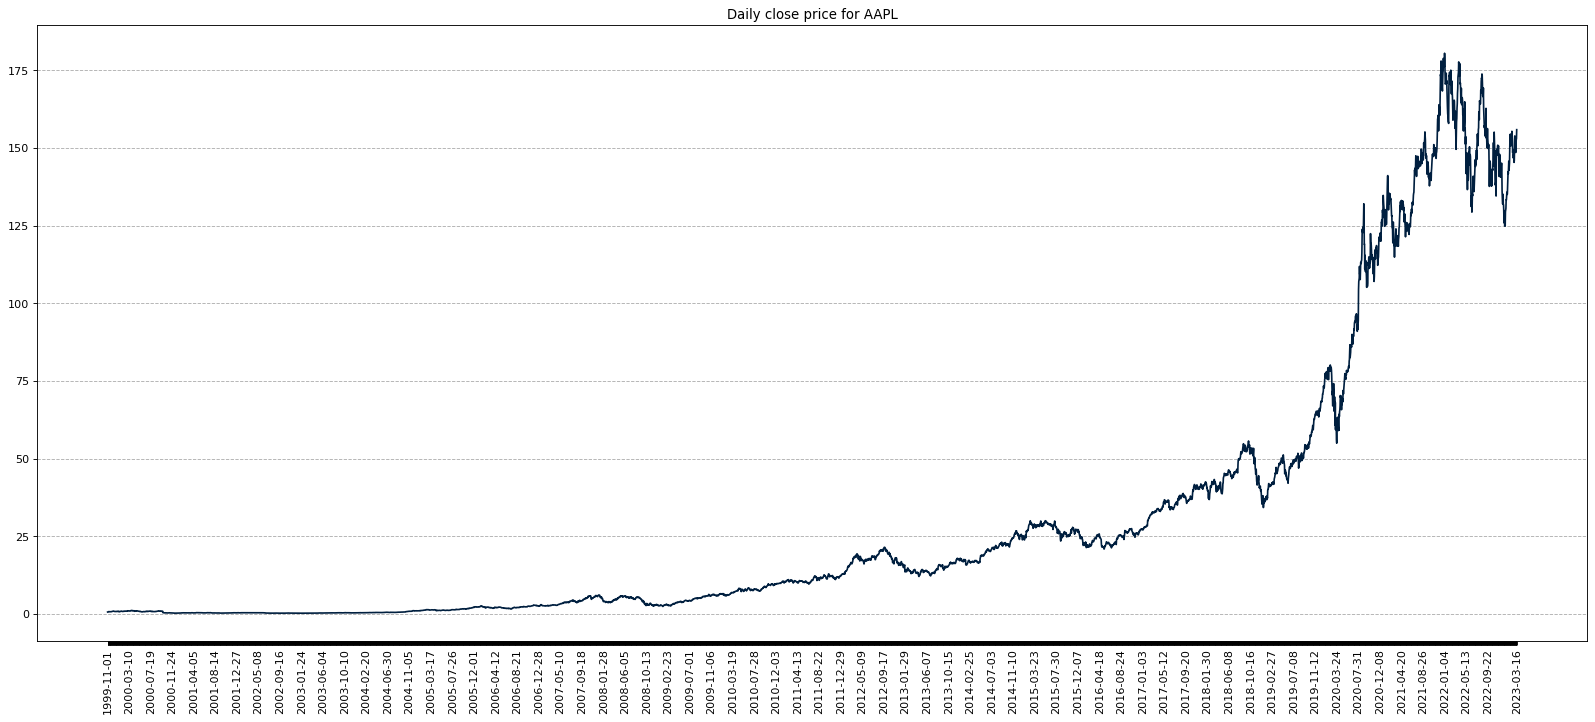

In [5]:
ts = TimeSeries(key=config["alpha_vantage"]["key"])
data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data, orient='index')
df = df.astype(float)

# Set the name of the first column (date data)
df.reset_index(inplace=True)
df.rename(columns={"index": "date"}, inplace=True)


# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)
#df['date'] = df['date'].apply(str_to_datetime)
#df["date"] = df["date"].dt.strftime("%Y-%m-%d")
df = df.iloc[::-1].reset_index(drop=True)
data_date = [date for date in df["date"]]
num_data_points = len(data_date)
fig = figure(figsize=(25, 10), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

# Plot the date as x, adjust close price as y
plt.plot(data_date, df['5. adjusted close'], color=config["plots"]["color_actual"])

# xTicks makes dates displayed better
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
# Chart title
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"])
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.show()

In [6]:
def get_new_df(df, new_date):
    df['date'] = pd.to_datetime(df['date'])
    new_date = pd.to_datetime(new_date)
    df = df.loc[df['date'] >= new_date]
    df["date"] = df["date"].dt.strftime("%Y-%m-%d")
    df = df.drop(columns = ['7. dividend amount', '8. split coefficient'])
    return df
df = get_new_df(df, '2018-01-01')
df

C:\Users\nhanb\AppData\Local\Temp\ipykernel_11900\901221369.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = df["date"].dt.strftime("%Y-%m-%d")


,date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume
4571,2018-01-02,170.160,172.300,169.2600,172.26,40.834711,25048048.0
4572,2018-01-03,172.530,174.550,171.9600,172.23,40.827599,28819653.0
4573,2018-01-04,172.540,173.470,172.0800,173.03,41.017241,22211345.0
4574,2018-01-05,173.440,175.370,173.0500,175.00,41.484235,23016177.0
4575,2018-01-08,174.350,175.610,173.9300,174.35,41.330151,20134092.0
...,...,...,...,...,...,...,...
5876,2023-03-10,150.210,150.940,147.6096,148.50,148.500000,68572400.0
5877,2023-03-13,147.805,153.140,147.7000,150.47,150.470000,84457122.0
5878,2023-03-14,151.280,153.400,150.1000,152.59,152.590000,73695893.0
5879,2023-03-15,151.190,153.245,149.9200,152.99,152.990000,77167866.0


## Data preparation: normalizing raw financial data

In [7]:
# def to_array(df):
#     open_price, high_price, low_price, close_price, adjusted_close_price = [], [], [], [], []
#     open_price = df['1. open'].to_numpy()
#     high_price = df['2. high'].to_numpy()
#     low_price = df['3. low'].to_numpy()
#     close_price = df['4. close'].to_numpy()
#     adjusted_close_price = df['5. adjusted close'].to_numpy()
#     return open_price, high_price, low_price, close_price, adjusted_close_price

# open_price, high_price, low_price, close_price, adjusted_close_price = to_array(df)

def prepare_new_shape(x, window_size):
    n_row = x.shape[0] - window_size + 1
    unseen_row = x.shape[0] - window_size - config['model']['output_dates'] + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides = (x.strides[0], x.strides[0])) 
    return output[:unseen_row],  output[unseen_row:]

def SMA(x, window_size):
    #output = [sum(row) / len(row) for row in x]
    i = 0
    sma = []
    while i < (len(x) - window_size + 1):
        window = x[i:i+window_size]
        window_avg = np.sum(window)/window_size
        sma.append(window_avg)
        i += 1   
    sma = [float('nan')]*(window_size-1) + sma
    return sma
sma = SMA(df['4. close'].values, config['data']['window_size'])

def EMA(x, smoothing, window_size):
    k = smoothing/(window_size + 1)
    ema = []
    ema.append(x[0])
    i = 1
    while i < (len(x) - window_size + 1):
        window_avg = x[i]*k + ema[i-1]*(1-k)
        ema.append(window_avg)
        i += 1
    ema = [float('nan')]*(window_size-1) + ema
    return ema
ema = EMA(np.array(df['4. close']), config['data']['smoothing'], config['data']['window_size'])

def RSI(df, window_size, ema=True):
    delta_close = df['4. close'].diff()
    up = delta_close.clip(lower=0)
    down = -1 * delta_close.clip(upper=0)
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = window_size - 1, adjust=True, min_periods = window_size).mean()
        ma_down = down.ewm(com = window_size - 1, adjust=True, min_periods = window_size).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = window_size, adjust=False).mean()
        ma_down = down.rolling(window = window_size, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi.to_numpy().tolist()
rsi = RSI(df, config['data']['window_size'])
def VWAP(df, window_size):
    close = np.array(df['4. close'])
    vol = np.array(df['6. volume'])
    cum_price_volume = np.cumsum(close * vol)
    cum_volume = np.cumsum(vol)
    vwap = cum_price_volume[window_size-1:] / cum_volume[window_size-1:]
    vwap = vwap.tolist()
    vwap = [float('nan')]*(window_size-1) + vwap
    return vwap
vwap = VWAP(df, config['data']['window_size'])

'''
https://oxfordstrat.com/trading-strategies/hull-moving-average/
'''
def WMA(s, window_size):
    wma = s.rolling(window_size).apply(lambda x: ((np.arange(window_size)+1)*x).sum()/(np.arange(window_size)+1).sum(), raw=True)
    return wma

def HMA(s, window_size):
    wma1 = WMA(s, window_size//2)
    wma2 = WMA(s, window_size)
    hma = WMA(wma1.multiply(2).sub(wma2), int(np.sqrt(window_size)))
    return hma.tolist()
hma = HMA(df['4. close'], config['data']['window_size'])   
    

<h3>Create Dataset and prepare data

In [8]:
dataset_df = pd.DataFrame({'close': df['4. close'], 'sma' : sma, 'ema' : ema, 'rsi' : rsi, 'vwap' : vwap, 'hma' : hma})
dataset_df = dataset_df.drop(dataset_df.index[:15])
y = (dataset_df['close'] > dataset_df['close'].shift(1)).astype(int).fillna(0)
X = dataset_df.values.tolist()
y = y.values.tolist()

In [9]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

# Replace NaN values with the mean value for each feature
imp = SimpleImputer(strategy='mean')
X_train_imputed = imp.fit_transform(X_train)

# train a random forest classifier using scikit-learn
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_imputed, y_train)

# use the trained model to make predictions
X_test_imputed = imp.transform(X_test) # impute NaNs in test set using same imputer
y_pred = clf.predict(X_test_imputed)

# calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6126543209876543


In [11]:
clf.feature_importances_
import joblib

# Save the trained model object to a file
joblib.dump(clf, 'trend_forecast_rdc_1.pkl')


['trend_forecast_rdc_1.pkl']